In [1]:
import datetime as dt
import thredds_lsasaf_utils as tlu

import pandas as pd
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Point

import rasterio
from rasterio.mask import mask

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.families.links import Power
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log, identity

import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import patsy

import common_utils

In [2]:
def read_fused_data(filename):

    # Replace 'your_file.csv' with the path to your CSV file
    file_path = filename

    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Ensure the CSV contains 'lat' and 'lon' columns
    if 'lat' not in df.columns or 'lon' not in df.columns:
        raise ValueError("The CSV file must contain 'lat' and 'lon' columns")

    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Set the coordinate reference system (CRS) if known, e.g., WGS84 (EPSG:4326)
    gdf.set_crs(epsg=4326, inplace=True)

    return gdf

In [3]:
# Read data from .csv file
gdf = read_fused_data('../lu_fused_data_for_glm/lst_data.csv')

# Define target and LULC columns
target = 'temperature'  # Replace with your target column name

# Convert to Kelvin
gdf['temperature'] = gdf['temperature'] + 273.15

# Ensure categorical variables are treated as such
gdf['hour'] = gdf['hour'].astype('category')
gdf['month'] = gdf['month'].astype('category')
gdf['year'] = gdf['year'].astype('category')

# Drop the geometry column
gdf = gdf.drop(columns=['geometry'])

# Define LULC columns (all columns except the target)
lulc_columns = ['water', 'trees', 'flooded_veg', 'crop', 'built_area', 'bare_ground', 'range_land']

# Drop rows with missing values
gdf = gdf.dropna(subset=[target, 'hour', 'month', 'year'] + lulc_columns)

In [4]:
gdf.shape

(255101, 15)

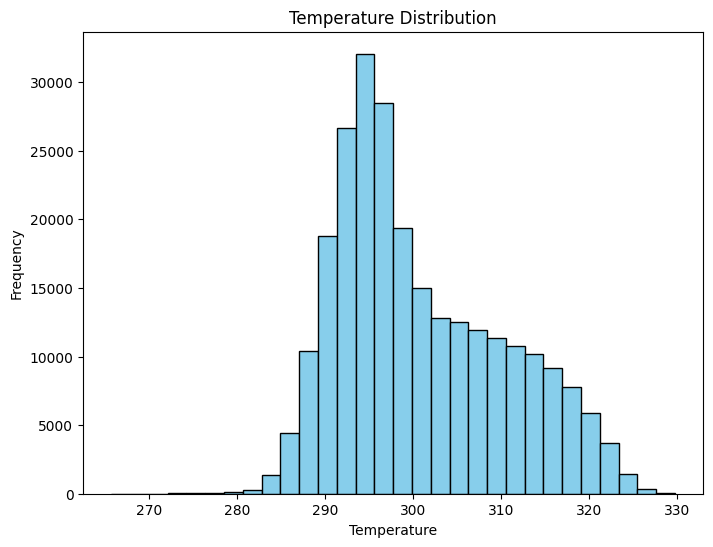

In [5]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'gdf' and the 'temperature' column exists
plt.figure(figsize=(8, 6))

# Plotting the histogram for temperature
plt.hist(gdf['temperature'], bins=30, color='skyblue', edgecolor='black')

# Adding title and labels
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [6]:

# Update the interaction formula to include 'month'
interaction_formula = f"{target} ~ C(year)  + C(month) + C(hour) * ({' + '.join(lulc_columns)})"
interaction_formula

# gdf = gdf.sample(frac=0.5, random_state=42)

# Step 2: Split the data into training and testing sets (75-25 split)
train_data, test_data = train_test_split(gdf, test_size=0.75)

import statsmodels.api as sm

# Step 3: Generate design matrices for train and test sets
y_train, X_train = patsy.dmatrices(interaction_formula, data=train_data, return_type='dataframe')
y_test, X_test = patsy.dmatrices(interaction_formula, data=test_data, return_type='dataframe')

# Step 4: Fit the GLM model on the training data
gamma_model = sm.GLM(y_train, X_train, family=sm.families.Gamma(link=sm.families.links.log()))
gamma_results = gamma_model.fit()


# Step 5: Display model summary
print(gamma_results.summary())


/home/emaximus/workspace/lsasaf_data_access/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:            temperature   No. Observations:                63775
Model:                            GLM   Df Residuals:                    63603
Model Family:                   Gamma   Df Model:                          171
Link Function:                    log   Scale:                      0.00010027
Method:                          IRLS   Log-Likelihood:            -1.6093e+05
Date:                Fri, 27 Dec 2024   Deviance:                       6.4224
Time:                        15:23:57   Pearson chi2:                     6.38
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

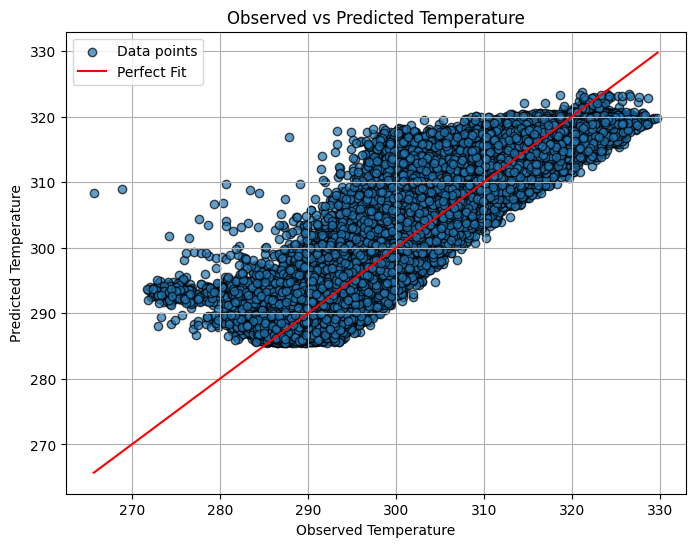

In [7]:

# Make predictions on the test data
y_pred = gamma_results.predict(X_test)

# Plot observed vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', label='Data points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Perfect Fit')
plt.xlabel("Observed Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Observed vs Predicted Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [8]:

import pickle

# Save the GLM model to a pickle file
with open('glm_model.pkl', 'wb') as file:
    pickle.dump(gamma_results, file)

print("GLM model saved as 'glm_model.pkl'")

# Save the model summary to a text file
with open('glm_model_summary.txt', 'w') as file:
    file.write(gamma_results.summary().as_text())

print("GLM model summary saved as 'glm_model_summary.txt'")

GLM model saved as 'glm_model.pkl'
GLM model summary saved as 'glm_model_summary.txt'


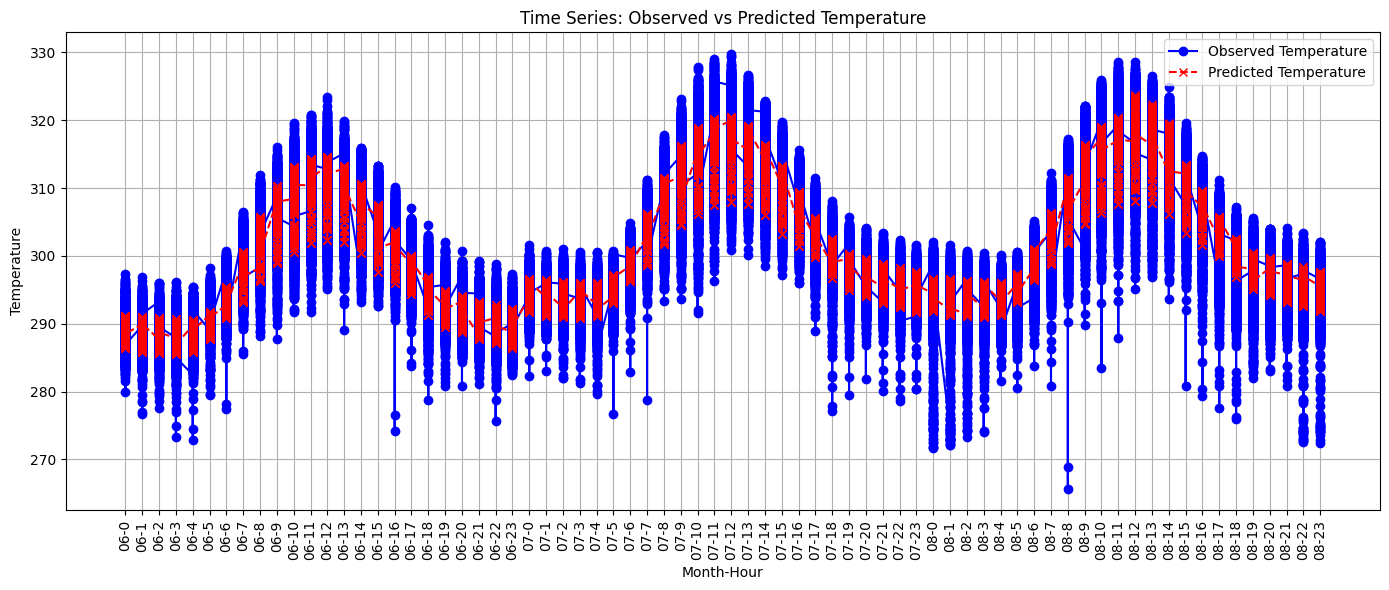

In [9]:
import matplotlib.pyplot as plt

# Create a combined 'month-hour' column for better visualization
test_data['month_str'] = test_data['month'].astype(str).str.zfill(2)

test_data['month_hour'] = test_data['month_str'].astype(str) + '-' + test_data['hour'].astype(str)

# Add predictions to the test dataset
test_data['observed'] = y_test.values
test_data['predicted'] = y_pred

# Sort by the combined 'month-hour' index for proper plotting
test_data = test_data.sort_values(by=['month_str', 'hour'])

# Plot observed vs predicted as a time series
plt.figure(figsize=(14, 6))
plt.plot(test_data['month_hour'], test_data['observed'], label='Observed Temperature', marker='o', linestyle='-', color='blue')
plt.plot(test_data['month_hour'], test_data['predicted'], label='Predicted Temperature', marker='x', linestyle='--', color='red')
plt.xlabel('Month-Hour')
plt.ylabel('Temperature')
plt.title('Time Series: Observed vs Predicted Temperature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Root Mean Squared Error:", round(rmse, 1))

Root Mean Squared Error: 3.1
